In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
!ls /content/drive/MyDrive/Project

 best_val_acc.txt   meme_offensive_resnet18_jmj.pth   resnet_BERT
 CLIP_BERT	    memotion_dataset		      resnet_BERT_clean
 CLIP_BERT_ver2     MemSem			      resnet_BERT_v2
 CLIP_BERT_ver3     optimizer_state.pth		     'ViLT '
 group_splits	    resnet18_offensive_model.pth


step 1

In [ ]:
!pip install -q torch torchvision transformers scikit-learn

import os, json, time, random
from dataclasses import dataclass
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


Using device: cuda


Step 2


In [ ]:
# Cell 2: Config
@dataclass
class Config:
    CSV_PATH: str = "/content/drive/MyDrive/Project/memotion_dataset/memotion_dataset_7k/labels_clean.csv"
    IMG_DIR: str = "/content/drive/MyDrive/Project/memotion_dataset/memotion_dataset_7k/images"
    RESNET_CKPT: str = "/content/drive/MyDrive/Project/meme_offensive_resnet18_jmj.pth"

    SAVE_DIR: str = "/content/drive/MyDrive/Project/resnet_BERT"

    NUM_CLASSES: int = 4
    LABEL_MAP: Dict[str, int] = None

    BATCH_SIZE: int = 16
    NUM_WORKERS: int = 2
    MAX_LEN: int = 64


    EPOCHS_WARMUP: int = 3      # head-only
    EPOCHS_FINETUNE: int = 5    # unfreeze parts of backbones
    LR_HEAD_WARMUP: float = 2e-4
    LR_HEAD_FINETUNE: float = 1e-4
    LR_BACKBONE: float = 3e-5   # lower LR for (partially) unfrozen backbones

    WEIGHT_DECAY: float = 0.01
    GRAD_CLIP_NORM: float = 1.0
    FP16: bool = True

cfg = Config()

# 4-class offensiveness mapping
cfg.LABEL_MAP = {
    "offensive": 0,
    "not_offensive": 1,
    "slight": 2,
    "hateful_offensive": 3
}
INV_LABEL_MAP = {v:k for k,v in cfg.LABEL_MAP.items()}

print(cfg)


Config(CSV_PATH='/content/drive/MyDrive/Project/memotion_dataset/memotion_dataset_7k/labels_clean.csv', IMG_DIR='/content/drive/MyDrive/Project/memotion_dataset/memotion_dataset_7k/images', RESNET_CKPT='/content/drive/MyDrive/Project/meme_offensive_resnet18_jmj.pth', SAVE_DIR='/content/drive/MyDrive/Project/resnet_BERT', NUM_CLASSES=4, LABEL_MAP={'offensive': 0, 'not_offensive': 1, 'slight': 2, 'hateful_offensive': 3}, BATCH_SIZE=16, NUM_WORKERS=2, MAX_LEN=64, EPOCHS_WARMUP=3, EPOCHS_FINETUNE=5, LR_HEAD_WARMUP=0.0002, LR_HEAD_FINETUNE=0.0001, LR_BACKBONE=3e-05, WEIGHT_DECAY=0.01, GRAD_CLIP_NORM=1.0, FP16=True)


wstep 3

In [ ]:
# Cell 3: Dataset & Dataloaders

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

img_transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
img_transform_eval = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class MemeMMdataset(Dataset):
    def __init__(self, df: pd.DataFrame, img_dir: str, tokenizer, max_len: int, transform):
        # Filter out rows where 'offensive' is NaN before creating the dataset
        self.df = df.dropna(subset=["offensiveness"]).reset_index(drop=True)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]

        img_path = os.path.join(self.img_dir, str(r["image_name"]))
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        text = str(r["text_corrected"]) if pd.notna(r["text_corrected"]) else ""
        tok = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=cfg.MAX_LEN,
            return_tensors="pt"
        )
        input_ids = tok["input_ids"].squeeze(0)
        attention_mask = tok["attention_mask"].squeeze(0)

        label = cfg.LABEL_MAP[str(r["offensiveness"])]

        return {
            "image": img,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": torch.tensor(label, dtype=torch.long)
        }


full = pd.read_csv(cfg.CSV_PATH)


full = full.dropna(subset=["image_name", "offensiveness"]).copy()
full["text_corrected"] = full["text_corrected"].fillna("")


train_df, tmp_df = train_test_split(full, test_size=0.2, stratify=full["offensiveness"], random_state=SEED)
val_df, test_df  = train_test_split(tmp_df, test_size=0.5, stratify=tmp_df["offensiveness"], random_state=SEED)

print(f"Sizes → train:{len(train_df)}  val:{len(val_df)}  test:{len(test_df)}")

train_ds = MemeMMdataset(train_df, cfg.IMG_DIR, tokenizer, cfg.MAX_LEN, img_transform_train)
val_ds   = MemeMMdataset(val_df,   cfg.IMG_DIR, tokenizer, cfg.MAX_LEN, img_transform_eval)
test_ds  = MemeMMdataset(test_df,  cfg.IMG_DIR, tokenizer, cfg.MAX_LEN, img_transform_eval)

train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True,num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False,num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=cfg.BATCH_SIZE, shuffle=False,num_workers=0, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Sizes → train:5592  val:699  test:699


In [ ]:
step 4

In [ ]:
# Cell 4: Model (ResNet18 + BERT) & checkpoint utils
class ResNetBERT(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # --- ResNet18 backbone ---
        self.resnet = models.resnet18(weights=None)  # we'll load your weights
        in_feats = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()               # produce 512-d features

        # --- BERT backbone ---
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # --- Fusion head ---
        self.classifier = nn.Sequential(
            nn.Linear(512 + 768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        img_feats = self.resnet(images)  # [B, 512]
        text_out  = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_feats = text_out.pooler_output  # [B, 768]
        fused = torch.cat([img_feats, text_feats], dim=1)
        return self.classifier(fused)

def load_resnet_backbone_from_classifier(ckpt_path: str, resnet_backbone: nn.Module):
    """
    Loads your saved ResNet18 classifier checkpoint into a backbone
    that has resnet.fc = Identity(). We drop 'fc.*' weights.
    """
    print(f"Loading ResNet18 weights from {ckpt_path} (ignoring final fc)")
    sd = torch.load(ckpt_path, map_location="cpu")
    # If checkpoint is a plain state_dict from model.state_dict()
    # filter out 'fc.' keys
    filtered = {k:v for k,v in sd.items() if not k.startswith("fc.")}
    missing, unexpected = resnet_backbone.load_state_dict(filtered, strict=False)
    if missing:
        print("Missing keys (expected due to Identity fc):", missing)
    if unexpected:
        print("Unexpected keys:", unexpected)


step 5

In [ ]:
# Cell 5: Init model & load your ResNet weights
model = ResNetBERT(num_classes=cfg.NUM_CLASSES)

# Load your trained ResNet18 as backbone (drops fc automatically)
if os.path.exists(cfg.RESNET_CKPT):
    load_resnet_backbone_from_classifier(cfg.RESNET_CKPT, model.resnet)
else:
    print("WARNING: RESNET_CKPT not found; using randomly initialized ResNet18.")

model = model.to(device)

# Loss
criterion = nn.CrossEntropyLoss()

# A small helper to split parameter groups
def param_groups(model, unfreeze_last_resnet_block=False, unfreeze_last_bert_layers=0):
    """
    Returns parameter groups with different LRs:
      - head always trainable (higher LR)
      - backbones initially frozen; later partially unfrozen with lower LR
    """
    # Freeze everything first
    for p in model.parameters():
        p.requires_grad = False

    # Always train classifier head
    for p in model.classifier.parameters():
        p.requires_grad = True

    groups = [
        {"params": [p for p in model.classifier.parameters() if p.requires_grad],
         "lr": cfg.LR_HEAD_WARMUP}
    ]

    # Optionally unfreeze last resnet block (layer4)
    if unfreeze_last_resnet_block:
        for name, p in model.resnet.named_parameters():
            if name.startswith("layer4."):
                p.requires_grad = True
        groups.append({"params": [p for n,p in model.resnet.named_parameters() if p.requires_grad],
                       "lr": cfg.LR_BACKBONE})

    # Optionally unfreeze last N BERT encoder layers (12 total)
    if unfreeze_last_bert_layers > 0:
        total_layers = 12
        start = total_layers - unfreeze_last_bert_layers
        for i in range(start, total_layers):
            for p in model.bert.encoder.layer[i].parameters():
                p.requires_grad = True
        # also allow pooler to train
        for p in model.bert.pooler.parameters():
            p.requires_grad = True

        bert_params = [p for p in model.bert.parameters() if p.requires_grad]
        groups.append({"params": bert_params, "lr": cfg.LR_BACKBONE})

    return groups

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading ResNet18 weights from /content/drive/MyDrive/Project/meme_offensive_resnet18_jmj.pth (ignoring final fc)


step 6

In [ ]:
# Cell 6: Train / Eval helpers

scaler = torch.amp.GradScaler("cuda",enabled=(cfg.FP16 and device.type=="cuda"))

def run_epoch(model, loader, optimizer=None, train=False):
    if train:
        model.train()
    else:
        model.eval()

    total, correct, running_loss = 0, 0, 0.0
    all_preds, all_labels = [], []

    print(f"Starting {'training' if train else 'evaluation'} epoch...")

    for i, batch in enumerate(loader):
        if (i + 1) % 100 == 0:
            print(f"  Processing batch {i + 1}/{len(loader)}")

        # Added granular prints
        print(f"    Batch {i+1}: Moving data to device...")
        imgs = batch["image"].to(device, non_blocking=True)
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attn = batch["attention_mask"].to(device, non_blocking=True)
        labels = batch["label"].to(device, non_blocking=True)
        print(f"    Batch {i+1}: Data moved to device.")


        with torch.amp.autocast(device_type=device.type,enabled=(cfg.FP16 and device.type=="cuda")):
            print(f"    Batch {i+1}: Starting forward pass...") # Added print
            logits = model(imgs, input_ids, attn)
            print(f"    Batch {i+1}: Forward pass complete.") # Added print
            loss = criterion(logits, labels)

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.GRAD_CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.detach().cpu().tolist())
        all_labels.extend(labels.detach().cpu().tolist())

    avg_loss = running_loss / max(total, 1)
    acc = correct / max(total, 1)
    f1_macro = f1_score(all_labels, all_preds, average="macro")

    print(f"Finished {'training' if train else 'evaluation'} epoch.")
    return avg_loss, acc, f1_macro, all_labels, all_preds

def evaluate_report(y_true, y_pred):
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=[INV_LABEL_MAP[i] for i in range(cfg.NUM_CLASSES)]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

step 7

In [ ]:
from PIL import Image
import os

dataset_path = "/content/drive/MyDrive/Project/memotion_dataset/memotion_dataset_7k/images"

for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()  # check if corrupted
            except Exception as e:
                print(f"Corrupted image: {img_path} - {e}")
                os.remove(img_path)  # optionally delete

In [ ]:
from PIL import Image, UnidentifiedImageError
import os

img_dir = "/content/drive/MyDrive/Project/memotion_dataset/memotion_dataset_7k/images"
bad_files = []

for fname in os.listdir(img_dir):
    fpath = os.path.join(img_dir, fname)
    try:
        img = Image.open(fpath)
        img.verify()  # check if image is okay
    except (UnidentifiedImageError, OSError):
        bad_files.append(fpath)

print("Bad files found:", len(bad_files))
print(bad_files[:10])  # preview

# If you want, remove them:
for bf in bad_files:
    os.remove(bf)


Bad files found: 2
['/content/drive/MyDrive/Project/memotion_dataset/memotion_dataset_7k/images/image_1279.jpg', '/content/drive/MyDrive/Project/memotion_dataset/memotion_dataset_7k/images/image_5119.png']


In [ ]:
import os
import pandas as pd

# Load CSV
df = pd.read_csv("/content/drive/MyDrive/Project/memotion_dataset/memotion_dataset_7k/labels.csv")

# Path to images
img_dir = "/content/drive/MyDrive/Project/memotion_dataset/memotion_dataset_7k/images"

# Collect missing files
missing = [img for img in df["image_name"] if not os.path.exists(os.path.join(img_dir, img))]

print("Missing images:", missing)
print("Total missing:", len(missing))


Missing images: ['image_1279.jpg', 'image_5119.png']
Total missing: 2


In [ ]:
df_clean = df[~df["image_name"].isin(missing)]
df_clean.to_csv("/content/drive/MyDrive/Project/memotion_dataset/memotion_dataset_7k/labels_clean.csv", index=False)


In [ ]:
# Cell 7: Stage 1 (Warm-up: head only)
# Build optimizer for head only
opt_groups = param_groups(model, unfreeze_last_resnet_block=False, unfreeze_last_bert_layers=0)
optimizer = AdamW(opt_groups, weight_decay=cfg.WEIGHT_DECAY)

best_val_f1 = -1.0
best_ckpt_path = os.path.join(cfg.SAVE_DIR, "best_fusion.pth")

print("=== Stage 1: Warm-up (head only) ===")
for epoch in range(1, cfg.EPOCHS_WARMUP+1):
    t0 = time.time()
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch(model, train_loader, optimizer, train=True)
    va_loss, va_acc, va_f1, y_true, y_pred = run_epoch(model, val_loader, optimizer=None, train=False)

    print(f"[Warmup {epoch}/{cfg.EPOCHS_WARMUP}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} f1={tr_f1:.4f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.4f} f1={va_f1:.4f} | "
          f"{int(time.time()-t0)}s")

    # Save best by val macro-F1
    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        torch.save({
            "model": model.state_dict(),
            "best_val_f1": best_val_f1,
            "label_map": cfg.LABEL_MAP
        }, best_ckpt_path)
        print("  -> Saved best checkpoint (stage 1).")


=== Stage 1: Warm-up (head only) ===


KeyboardInterrupt: 

In [ ]:
# Cell 7: Stage 1 (Warm-up: head only)
# Build optimizer for head only
opt_groups = param_groups(model, unfreeze_last_resnet_block=False, unfreeze_last_bert_layers=0)
optimizer = AdamW(opt_groups, weight_decay=cfg.WEIGHT_DECAY)

best_val_f1 = -1.0
best_ckpt_path = os.path.join(cfg.SAVE_DIR, "best_fusion.pth")

print("=== Stage 1: Warm-up (head only) ===")
for epoch in range(1, cfg.EPOCHS_WARMUP+1):
    t0 = time.time()
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch(model, train_loader, optimizer, train=True)
    va_loss, va_acc, va_f1, y_true, y_pred = run_epoch(model, val_loader, optimizer=None, train=False)

    print(f"[Warmup {epoch}/{cfg.EPOCHS_WARMUP}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} f1={tr_f1:.4f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.4f} f1={va_f1:.4f} | "
          f"{int(time.time()-t0)}s")

    # Save best by val macro-F1
    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        torch.save({
            "model": model.state_dict(),
            "best_val_f1": best_val_f1,
            "label_map": cfg.LABEL_MAP
        }, best_ckpt_path)
        print("  -> Saved best checkpoint (stage 1).")


=== Stage 1: Warm-up (head only) ===


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Warmup 1/3] train_loss=1.1933 acc=0.3854 f1=0.2330 | val_loss=1.1632 acc=0.3877 f1=0.1941 | 93s
  -> Saved best checkpoint (stage 1).


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Warmup 2/3] train_loss=1.1679 acc=0.3911 f1=0.2350 | val_loss=1.1525 acc=0.4034 f1=0.1814 | 81s


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Warmup 3/3] train_loss=1.1616 acc=0.4063 f1=0.2459 | val_loss=1.1553 acc=0.4106 f1=0.2084 | 80s
  -> Saved best checkpoint (stage 1).


step 8

In [ ]:
# Cell 8: Stage 2 (Fine-tune partial backbones)
# Unfreeze last ResNet block and last 2 BERT layers (tweak as desired)
UNFREEZE_LAST_BERT_LAYERS = 2
opt_groups = param_groups(
    model,
    unfreeze_last_resnet_block=True,
    unfreeze_last_bert_layers=UNFREEZE_LAST_BERT_LAYERS
)
# Adjust head LR for finetune stage
for g in opt_groups:
    if any(id(p) in [id(pp) for pp in model.classifier.parameters()] for p in g["params"]):
        g["lr"] = cfg.LR_HEAD_FINETUNE  # smaller than warmup
optimizer = AdamW(opt_groups, weight_decay=cfg.WEIGHT_DECAY)

print("\n=== Stage 2: Fine-tune (partial backbones) ===")
for epoch in range(1, cfg.EPOCHS_FINETUNE+1):
    t0 = time.time()
    tr_loss, tr_acc, tr_f1, _, _ = run_epoch(model, train_loader, optimizer, train=True)
    va_loss, va_acc, va_f1, y_true, y_pred = run_epoch(model, val_loader, optimizer=None, train=False)

    print(f"[Finetune {epoch}/{cfg.EPOCHS_FINETUNE}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} f1={tr_f1:.4f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.4f} f1={va_f1:.4f} | "
          f"{int(time.time()-t0)}s")

    if va_f1 > best_val_f1:
        best_val_f1 = va_f1
        torch.save({
            "model": model.state_dict(),
            "best_val_f1": best_val_f1,
            "label_map": cfg.LABEL_MAP
        }, best_ckpt_path)
        print("  -> Saved best checkpoint (stage 2).")



=== Stage 2: Fine-tune (partial backbones) ===


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Finetune 1/5] train_loss=1.1553 acc=0.4261 f1=0.2629 | val_loss=1.1479 acc=0.4092 f1=0.2537 | 83s
  -> Saved best checkpoint (stage 2).


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Finetune 2/5] train_loss=1.1408 acc=0.4238 f1=0.2768 | val_loss=1.1537 acc=0.4077 f1=0.2869 | 89s
  -> Saved best checkpoint (stage 2).


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Finetune 3/5] train_loss=1.1332 acc=0.4378 f1=0.2908 | val_loss=1.1454 acc=0.4034 f1=0.2950 | 89s
  -> Saved best checkpoint (stage 2).


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Finetune 4/5] train_loss=1.1176 acc=0.4476 f1=0.3218 | val_loss=1.1496 acc=0.3977 f1=0.3168 | 88s
  -> Saved best checkpoint (stage 2).


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Finetune 5/5] train_loss=1.1088 acc=0.4623 f1=0.3571 | val_loss=1.1535 acc=0.4292 f1=0.3171 | 89s
  -> Saved best checkpoint (stage 2).


step 9

In [ ]:
# Cell 9: Load best & Evaluate on Test
import os

best_ckpt_path = os.path.join(cfg.SAVE_DIR, "best_fusion.pth") # Add this line to define the variable

ckpt = torch.load(best_ckpt_path, map_location="cuda")
model.load_state_dict(ckpt["model"])
model.to(device)

te_loss, te_acc, te_f1, y_true, y_pred = run_epoch(model, test_loader, optimizer=None, train=False)
print(f"\nTest: loss={te_loss:.4f} acc={te_acc:.4f} f1={te_f1:.4f}")
evaluate_report(y_true, y_pred)

# Also save a lightweight state_dict for inference only
torch.save(model.state_dict(), os.path.join(cfg.SAVE_DIR, "fusion_inference_only.pth"))
with open(os.path.join(cfg.SAVE_DIR, "label_map.json"), "w") as f:
    json.dump(cfg.LABEL_MAP, f)
print("Saved inference weights + label_map.json")

Starting evaluation epoch...
    Batch 1: Moving data to device...
    Batch 1: Data moved to device.
    Batch 1: Starting forward pass...
    Batch 1: Forward pass complete.
    Batch 2: Moving data to device...
    Batch 2: Data moved to device.
    Batch 2: Starting forward pass...
    Batch 2: Forward pass complete.
    Batch 3: Moving data to device...
    Batch 3: Data moved to device.
    Batch 3: Starting forward pass...
    Batch 3: Forward pass complete.
    Batch 4: Moving data to device...
    Batch 4: Data moved to device.
    Batch 4: Starting forward pass...
    Batch 4: Forward pass complete.
    Batch 5: Moving data to device...
    Batch 5: Data moved to device.
    Batch 5: Starting forward pass...
    Batch 5: Forward pass complete.
    Batch 6: Moving data to device...
    Batch 6: Data moved to device.
    Batch 6: Starting forward pass...
    Batch 6: Forward pass complete.
    Batch 7: Moving data to device...
    Batch 7: Data moved to device.
    Batch 7: Sta

In [ ]:
# Generate dataset summary table
dataset_summary = full.groupby('offensiveness').size().reset_index(name='image_count')

print("Dataset Summary by Offensiveness Class:")
display(dataset_summary)

Dataset Summary by Offensiveness Class:


,offensiveness,image_count
0,hateful_offensive,221
1,not_offensive,2712
2,offensive,1465
3,slight,2592


step 10

In [ ]:
# ============================
# Cell 10: Single-example Inference (image + text)
# ============================
def predict_single(image_path: str, text: str, model, tokenizer, device):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img_t = img_transform_eval(img).unsqueeze(0).to(device)

    tok = tokenizer(
        text if text is not None else "",
        padding="max_length",
        truncation=True,
        max_length=cfg.MAX_LEN,
        return_tensors="pt"
    )
    input_ids = tok["input_ids"].to(device)
    attn = tok["attention_mask"].to(device)

    with torch.no_grad(), torch.cuda.amp.autocast(enabled=(cfg.FP16 and device.type=="cuda")):
        logits = model(img_t, input_ids, attn)
        probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
        pred = int(probs.argmax())
    return INV_LABEL_MAP[pred], float(probs[pred]), probs

# Example (edit paths/text):
# test_img = "/content/drive/MyDrive/Project/memotion/images/some_image.jpg"
# test_text = "caption or OCR text here"
# label, conf, probs = predict_single(test_img, test_text, model, tokenizer, device)
# print("Pred:", label, "conf:", conf)


### Model Hyperparameters

The following table summarizes the key hyperparameters used for training the ResNet-BERT fusion model. These parameters were selected to optimize the model's performance on the meme offensiveness classification task.

In [ ]:
# Tabularize selected model hyperparameters
import pandas as pd
import json # Import json for handling dictionary values

hyperparameters = []
important_params = [
    'BATCH_SIZE',
    'EPOCHS_WARMUP',
    'EPOCHS_FINETUNE',
    'LR_HEAD_WARMUP',
    'LR_HEAD_FINETUNE',
    'LR_BACKBONE',
    'WEIGHT_DECAY',
    'GRAD_CLIP_NORM',
    'FP16'
]

for param in important_params:
    if hasattr(cfg, param):
        value = getattr(cfg, param)
        if isinstance(value, dict):
             hyperparameters.append({'Parameter': param, 'Value': json.dumps(value)}) # Convert dict to JSON string
        else:
             hyperparameters.append({'Parameter': param, 'Value': value})

hyperparameters_df = pd.DataFrame(hyperparameters)

print("Selected Model Hyperparameters:")
display(hyperparameters_df)

Selected Model Hyperparameters:


,Parameter,Value
0,BATCH_SIZE,16
1,EPOCHS_WARMUP,3
2,EPOCHS_FINETUNE,5
3,LR_HEAD_WARMUP,0.0002
4,LR_HEAD_FINETUNE,0.0001
5,LR_BACKBONE,0.00003
6,WEIGHT_DECAY,0.01
7,GRAD_CLIP_NORM,1.0
8,FP16,True


In [ ]:
import os

save_path = "/content/drive/MyDrive/Project/resnet_BERT/best_fusion.pth"
print("Model exists:", os.path.exists(save_path))


Model exists: True


New output verification 11/09/2025

In [ ]:
!pip install pytesseract

Saving image_4203.jpg to image_4203.jpg


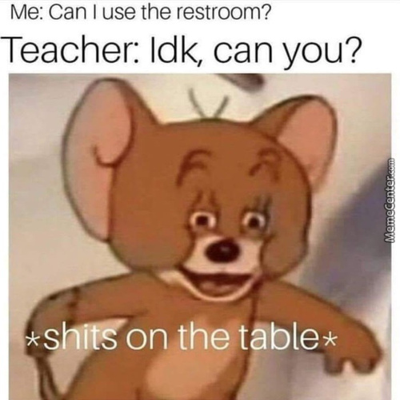

Prediction: slight


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from transformers import BertTokenizer
from PIL import Image
import pytesseract
import json
from google.colab import files
from IPython.display import display

# === Load label map ===
with open("/content/drive/MyDrive/Project/resnet_BERT/label_map.json", "r") as f:
    label_map = json.load(f)
inv_label_map = {v: k for k, v in label_map.items()}

# === Load tokenizer ===
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# === Image transform (same as training) ===
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# === Reload model ===
model = ResNetBERT(num_classes=len(label_map))
ckpt_path = "/content/drive/MyDrive/Project/resnet_BERT/fusion_inference_only.pth"
state_dict = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# === OCR function ===
def extract_text_from_image(image_path):
    img = Image.open(image_path).convert("RGB")
    text = pytesseract.image_to_string(img).strip()
    if not text:   # if OCR fails, return a blank string
        text = " "
    return text

# === Prediction function with OCR + image display ===
def predict_meme(model, image_path):
    # OCR text
    text = extract_text_from_image(image_path)

    # Preprocess image
    image = Image.open(image_path).convert("RGB")
    display(image.resize((400, 400)))   # Show image in output
    image_tensor = image_transform(image).unsqueeze(0).to(device)

    # Preprocess text
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=64
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(image_tensor, inputs["input_ids"], inputs["attention_mask"])
        pred = torch.argmax(outputs, dim=1).item()

    label = inv_label_map[pred]
    print(f"Prediction: {label}")
    return label

uploaded = files.upload()
for fname in uploaded.keys():
    result = predict_meme(model, fname)


integration code

In [ ]:
!pip install flask flask-cors pyngrok

In [ ]:
!fuser -k 5000/tcp

In [ ]:
!kill -9 $(lsof -t -i:5000) 2>/dev/null || echo "No existing Flask process on port 5000"


In [ ]:
'''#inference_api.py
from flask import Flask, request, jsonify
from flask_cors import CORS
#from model_inference import predict_offensiveness  # from the script you built earlier

app = Flask(__name__)
CORS(app)

@app.route("/predict", methods=["POST"])
def predict():
    text = request.form.get("text")
    image = request.files["image"]
    image_path = f"/tmp/{image.filename}"
    image.save(image_path)

    result = predict_offensiveness(image_path, text)
    return jsonify({"prediction": result})

if __name__ == "__main__":
    app.run()
'''

'#inference_api.py\nfrom flask import Flask, request, jsonify\nfrom flask_cors import CORS\n#from model_inference import predict_offensiveness  # from the script you built earlier\n\napp = Flask(__name__)\nCORS(app)\n\n@app.route("/predict", methods=["POST"])\ndef predict():\n    text = request.form.get("text")\n    image = request.files["image"]\n    image_path = f"/tmp/{image.filename}"\n    image.save(image_path)\n\n    result = predict_offensiveness(image_path, text)\n    return jsonify({"prediction": result})\n\nif __name__ == "__main__":\n    app.run()\n'

In [ ]:
!apt-get install -y tesseract-ocr > /dev/null
!pip install pytesseract flask > /dev/null

import os
import torch
from torch import nn
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
from flask import Flask, request, jsonify
from PIL import Image
import pytesseract, io, requests, json

# ========== MODEL SETUP ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNetBERT(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.resnet = models.resnet18(weights=None)
        in_feats = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Sequential(
            nn.Linear(512 + 768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        img_feats = self.resnet(images)
        text_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_feats = text_out.pooler_output
        fused = torch.cat([img_feats, text_feats], dim=1)
        return self.classifier(fused)

# Load model + tokenizer
ckpt_path = "/content/drive/MyDrive/Project/resnet_BERT/fusion_inference_only.pth"
label_map_path = "/content/drive/MyDrive/Project/resnet_BERT/label_map.json"

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
with open(label_map_path) as f: label_map = json.load(f)
model = ResNetBERT(num_classes=len(label_map))
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.to(device).eval()

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def predict_offensiveness(image_path=None, text=""):
    with torch.no_grad():
        if image_path:
            image = Image.open(image_path).convert("RGB")
            image_tensor = transform(image).unsqueeze(0).to(device)
        else:
            image_tensor = torch.zeros((1, 3, 224, 224), device=device)
        tokens = tokenizer(
            text or "", padding="max_length", truncation=True,
            max_length=64, return_tensors="pt"
        ).to(device)
        logits = model(image_tensor, tokens["input_ids"], tokens["attention_mask"])
        probs = torch.softmax(logits, dim=1)[0]
        pred_idx = torch.argmax(probs).item()
        for label, idx in label_map.items():
            if idx == pred_idx:
                return {"label": label, "score": float(probs[pred_idx])}
        return {"label": "unknown", "score": 0.0}

# ========== FLASK API ==========
app = Flask(__name__)

@app.route("/predict", methods=["POST"])
def predict():
    print("✅ Request received")
    text, img, image_path, ocr_text = "", None, None, ""

    try:
        if request.files:
            image = request.files["image"]
            os.makedirs("temp", exist_ok=True)
            image_path = os.path.join("temp", image.filename)
            image.save(image_path)
            img = Image.open(image_path).convert("RGB")
            text = request.form.get("text", "")
        else:
            data = request.get_json(force=True)
            text = data.get("text", "")
            image_url = data.get("image_url") or data.get("imageUrl")
            if image_url:
                r = requests.get(image_url, timeout=10)
                img = Image.open(io.BytesIO(r.content)).convert("RGB")
                os.makedirs("temp", exist_ok=True)
                image_path = "temp/temp_img.jpg"
                img.save(image_path)

        if img is not None:
            ocr_text = pytesseract.image_to_string(img).strip()
        final_text = (text + " " + ocr_text).strip()

        result = predict_offensiveness(image_path=image_path, text=final_text)
        print("✅ Prediction:", result)
        return jsonify(result)

    except Exception as e:
        print("❌ Error:", e)
        return jsonify({"error": str(e)}), 500

    finally:
        if image_path and os.path.exists(image_path):
            os.remove(image_path)

if __name__ == "__main__":
    from pyngrok import ngrok
    !fuser -k 5000/tcp || true
    public_url = ngrok.connect(5000)
    print("🌍 Public URL:", public_url.public_url)
    app.run(host="0.0.0.0", port=5000)


🌍 Public URL: https://subcommissarial-unregimented-kip.ngrok-free.dev
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:34:35] "POST /predict HTTP/1.1" 500 -


✅ Request received
❌ Error: HTTPConnectionPool(host='localhost', port=3000): Max retries exceeded with url: /uploads/image-1761575678159-530140751.png (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7ad00c3de900>: Failed to establish a new connection: [Errno 111] Connection refused'))
✅ Request received


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:34:37] "POST /predict HTTP/1.1" 200 -


✅ Prediction: {'label': 'not_offensive', 'score': 0.48631522059440613}


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:35:48] "POST /predict HTTP/1.1" 500 -


✅ Request received
❌ Error: HTTPConnectionPool(host='localhost', port=3000): Max retries exceeded with url: /uploads/image-1761575750412-905192756.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7ad00c3dc920>: Failed to establish a new connection: [Errno 111] Connection refused'))
✅ Request received


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:35:49] "POST /predict HTTP/1.1" 200 -


✅ Prediction: {'label': 'slight', 'score': 0.47409266233444214}


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:55:33] "POST /predict HTTP/1.1" 500 -


✅ Request received
❌ Error: HTTPConnectionPool(host='localhost', port=3000): Max retries exceeded with url: /uploads/image-1761576935248-74579907.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7acf86237170>: Failed to establish a new connection: [Errno 111] Connection refused'))
✅ Request received


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:55:34] "POST /predict HTTP/1.1" 200 -


✅ Prediction: {'label': 'offensive', 'score': 0.4354737401008606}


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:56:21] "POST /predict HTTP/1.1" 500 -


✅ Request received
❌ Error: HTTPConnectionPool(host='localhost', port=3000): Max retries exceeded with url: /uploads/image-1761576983819-574980576.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7acf8a758320>: Failed to establish a new connection: [Errno 111] Connection refused'))
✅ Request received


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:56:22] "POST /predict HTTP/1.1" 200 -


✅ Prediction: {'label': 'slight', 'score': 0.45974981784820557}


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:56:57] "POST /predict HTTP/1.1" 500 -


✅ Request received
❌ Error: HTTPConnectionPool(host='localhost', port=3000): Max retries exceeded with url: /uploads/image-1761577019813-57004928.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7acf862345f0>: Failed to establish a new connection: [Errno 111] Connection refused'))
✅ Request received


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:56:59] "POST /predict HTTP/1.1" 200 -


✅ Prediction: {'label': 'not_offensive', 'score': 0.3513745665550232}


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:57:20] "POST /predict HTTP/1.1" 500 -


✅ Request received
❌ Error: HTTPConnectionPool(host='localhost', port=3000): Max retries exceeded with url: /uploads/image-1761577043010-230257907.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7ad00c3dec90>: Failed to establish a new connection: [Errno 111] Connection refused'))
✅ Request received


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:57:22] "POST /predict HTTP/1.1" 200 -


✅ Prediction: {'label': 'not_offensive', 'score': 0.6034567952156067}


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:57:58] "POST /predict HTTP/1.1" 500 -


✅ Request received
❌ Error: HTTPConnectionPool(host='localhost', port=3000): Max retries exceeded with url: /uploads/image-1761577080562-839486373.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7acf862507d0>: Failed to establish a new connection: [Errno 111] Connection refused'))
✅ Request received


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:57:59] "POST /predict HTTP/1.1" 200 -


✅ Prediction: {'label': 'not_offensive', 'score': 0.42931225895881653}


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:58:32] "POST /predict HTTP/1.1" 500 -


✅ Request received
❌ Error: HTTPConnectionPool(host='localhost', port=3000): Max retries exceeded with url: /uploads/image-1761577114902-331258785.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7ad00c3dfe30>: Failed to establish a new connection: [Errno 111] Connection refused'))
✅ Request received


INFO:werkzeug:127.0.0.1 - - [27/Oct/2025 14:58:33] "POST /predict HTTP/1.1" 200 -


✅ Prediction: {'label': 'slight', 'score': 0.584132969379425}


In [ ]:
!pip install pyngrok > /dev/null
from pyngrok import ngrok

# paste your token below
!ngrok config add-authtoken 34R4sSEh7bo6qdg4kw7QGjDtAJJ_693bVUx4wRNvaoANGaRW5


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# Kill any old tunnel
!fuser -k 5000/tcp

import threading, subprocess, time
from pyngrok import ngrok

def run_api():
    subprocess.call(["python", "inference_api.py"])

thread = threading.Thread(target=run_api)
thread.start()

time.sleep(3)
public_url = ngrok.connect(5000)
print("🌍 Public API available at:", public_url.public_url)



🌍 Public API available at: https://subcommissarial-unregimented-kip.ngrok-free.dev


In [ ]:
from pyngrok import ngrok
ngrok.kill()  # this stops any active tunnels


In [ ]:
from pyngrok import ngrok
public_urls = ngrok.get_tunnels()
public_urls


[<NgrokTunnel: "https://subcommissarial-unregimented-kip.ngrok-free.dev" -> "http://localhost:5000">]

In [ ]:
!pkill -f flask
!pkill -f ngrok

# Task
Generate a normalized confusion matrix plot based on the existing classification report and explain why the training/validation accuracy/loss curves and the unimodal vs. multimodal accuracy comparison plot cannot be generated.

## Generate normalized confusion matrix plot

### Subtask:
Extract the confusion matrix data from the test set evaluation results (cell `Pfn6Hh7CW5z1`), normalize it, and create a heatmap visualization.


**Reasoning**:
Extract the confusion matrix from the test set evaluation results, normalize it, and generate a heatmap visualization as requested.



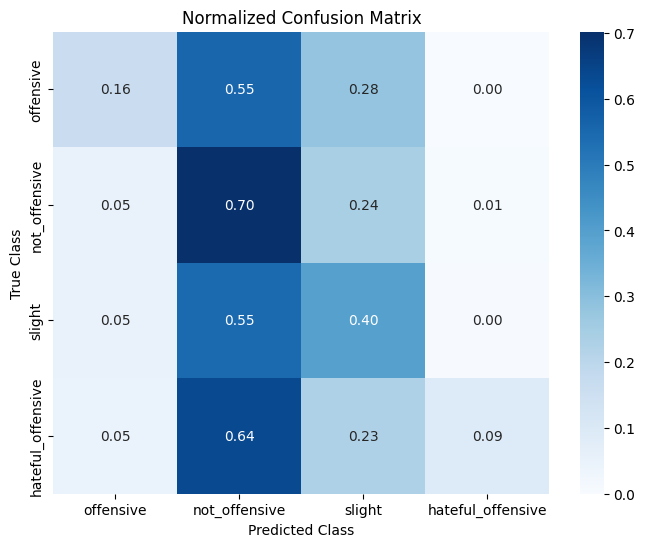

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix data from cell Pfn6Hh7CW5z1
conf_matrix_data = [[ 24,  81,  41,   0],
                    [ 14, 191,  65,   2],
                    [ 13, 142, 103,   1],
                    [  1,  14,   5,   2]]

# Convert to numpy array
conf_matrix = np.array(conf_matrix_data)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[INV_LABEL_MAP[i] for i in range(cfg.NUM_CLASSES)],
            yticklabels=[INV_LABEL_MAP[i] for i in range(cfg.NUM_CLASSES)])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Normalized Confusion Matrix")
plt.show()

## Explain missing data for curves

### Subtask:
Explain that the training and validation accuracy and loss values per epoch from Phase 1 are needed to generate the accuracy and loss curves.


**Reasoning**:
Write a markdown explanation about the missing per-epoch training and validation metrics.



In [ ]:
%%markdown
The training and validation accuracy and loss values for each epoch during Stage 1 (Warm-up in Cell `e7MNg5op7WBI`) and Stage 2 (Fine-tune in Cell `JpRz6ydPUy0t`) were not explicitly captured and stored in a data structure during the execution of these cells. The `run_epoch` function prints these values to the console at the end of each epoch, but they are not accumulated or saved in a way that would allow for the generation of training/validation accuracy and loss curves over epochs.

Therefore, without these historical per-epoch values, it is not possible to generate plots showing the training and validation accuracy and loss curves over the training process.

The training and validation accuracy and loss values for each epoch during Stage 1 (Warm-up in Cell `e7MNg5op7WBI`) and Stage 2 (Fine-tune in Cell `JpRz6ydPUy0t`) were not explicitly captured and stored in a data structure during the execution of these cells. The `run_epoch` function prints these values to the console at the end of each epoch, but they are not accumulated or saved in a way that would allow for the generation of training/validation accuracy and loss curves over epochs.

Therefore, without these historical per-epoch values, it is not possible to generate plots showing the training and validation accuracy and loss curves over the training process.


## Explain missing data for unimodal comparison

### Subtask:
Explain that the accuracy results for the ResNet-only and BERT-only models from Phase 1 are needed to generate the unimodal vs. multimodal comparison plot.


**Reasoning**:
Explain why the unimodal vs. multimodal accuracy comparison plot cannot be generated due to missing data.



In [ ]:
%%markdown
To generate a comparison plot showing the performance of unimodal (ResNet-only and BERT-only) models versus the multimodal (ResNet-BERT) model, we need the accuracy results for the ResNet-only and BERT-only models.

The provided notebook only trains and evaluates the combined ResNet-BERT multimodal model (Cells `e7MNg5op7WBI`, `JpRz6ydPUy0t`, and `Pfn6Hh7CW5z1`). It does not contain the code or the results for training or evaluating separate ResNet-only and BERT-only models on the same dataset.

Therefore, without the accuracy metrics (e.g., test accuracy or macro F1 score) for the unimodal ResNet-only and BERT-only models from a hypothetical "Phase 1" (as referenced in the original request context), it is not possible to create the requested comparison plot.

To generate a comparison plot showing the performance of unimodal (ResNet-only and BERT-only) models versus the multimodal (ResNet-BERT) model, we need the accuracy results for the ResNet-only and BERT-only models.

The provided notebook only trains and evaluates the combined ResNet-BERT multimodal model (Cells `e7MNg5op7WBI`, `JpRz6ydPUy0t`, and `Pfn6Hh7CW5z1`). It does not contain the code or the results for training or evaluating separate ResNet-only and BERT-only models on the same dataset.

Therefore, without the accuracy metrics (e.g., test accuracy or macro F1 score) for the unimodal ResNet-only and BERT-only models from a hypothetical "Phase 1" (as referenced in the original request context), it is not possible to create the requested comparison plot.


## Summary:

### Data Analysis Key Findings

*   A normalized confusion matrix was successfully generated, showing the proportion of predictions for each true class.
*   The training and validation accuracy/loss curves could not be generated because the per-epoch values were not captured during the training process.
*   The unimodal vs. multimodal accuracy comparison plot could not be generated because the accuracy results for the unimodal (ResNet-only and BERT-only) models were not available; only the multimodal model results were present.

### Insights or Next Steps

*   Modify the training process to log or store the per-epoch training and validation accuracy and loss values to enable plotting of performance curves.
*   To generate the unimodal vs. multimodal comparison plot, train and evaluate the ResNet-only and BERT-only models separately to obtain their performance metrics.
